In [1]:
import sys
# in order that the parent directory can be accessed, as this notebook
# is in the 'notebooks/' subdirectory
sys.path[1:1] = ['..']
%load_ext autoreload
%autoreload 2

In [2]:
from bayesianAB.event_stream import one_simulation_until_stopping_condition
from bayesianAB.many_simulations import many_simulations_to_the_stopping_condition, \
    get_one_row_per_simulation, \
    many_sims_many_stopping_conditions
import pandas as pd
from bayesianAB.risk import risk, slow_risk

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# See my blog post here:  http://aaronmcdaid.com/blog.posts/multiplot_from_generator/
from notebook_utils import multiplot_from_generator

In [5]:
from octotools.cache import Cache
cache = Cache()

## No true difference

If there is zero difference between the two means, then both the _expected loss_ and the _expected gain_ will tend towards zero. If there truly is a positive effect, the expected gain will tend towards the true positive effect, and the expected loss will tend to zero. And finally, if there truly is a negative effect, then the expected loss will tend towards the true effect and the expected gain will tend towards zero.

We see this in the next few plots. The first plot is just one experiment running to a sample size of 100, plotting the expected loss (EL, blue) and the expected gain (EG, orange).

The second plot shows 25 experiments, each running up to a sample size of 500, with the 25 traces of EL on top of each other. The third plot is the same as the second, but with a small positive true effect in order to show that the EL tends towards zero more quickly.

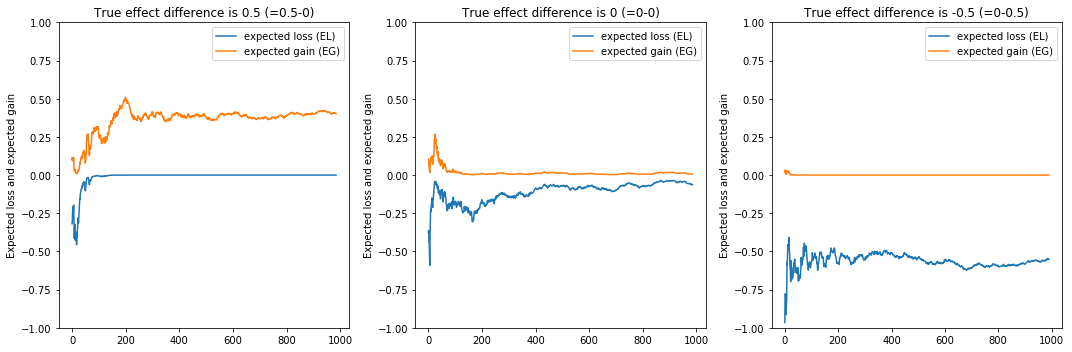

In [6]:
stopping_condition = 'total_sample_size == 1000'

def _plotter():
    for means in [([0, 0.5]), ([0,0]), ([0.5, 0])]:
        sim = one_simulation_until_stopping_condition(
            weights = [0.5, 0.5],
            means = means,
            stdevs = [1, 1],
            stopping_condition = stopping_condition)
        yield # 'multiplot_from_generator' requires a 'yield' before each plot
        plt.plot(sim.EL, label='expected loss (EL)');
        plt.plot(sim.EG, label='expected gain (EG)');
        plt.title('True effect difference is {} (={}-{})'.format(means[1]-means[0], means[1], means[0]))
        plt.ylabel('Expected loss and expected gain')
        plt.tight_layout()
        plt.ylim(-1, 1)
        plt.legend()
        
multiplot_from_generator(_plotter(), 3)

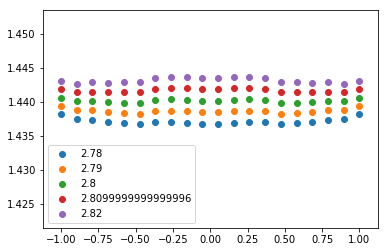

In [7]:
locs = np.linspace(-1, 1, 20)
x = pd.DataFrame([(-risk(0, loc, 1), -risk(0, -loc, 1)) for loc in locs], columns=['EL','EG'])
for _p in np.linspace(2.78, 2.82, 5):
    p = 1/_p
    plt.scatter(locs, x.EL**p + x.EG**p, label=_p);
plt.legend()

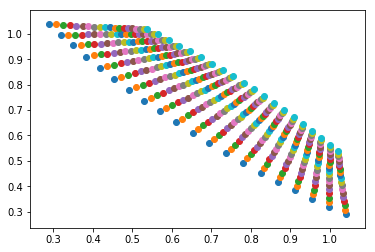

In [8]:
locs = np.linspace(-1, 1, 20)
x = pd.DataFrame([(-risk(0, loc, 1), -risk(0, -loc, 1)) for loc in locs], columns=['EL','EG'])
for _p in np.linspace(2, 4, 20):
    p = 1/_p
    plt.scatter(x.EL**p, x.EG**p, label=p);
    
#plt.legend()

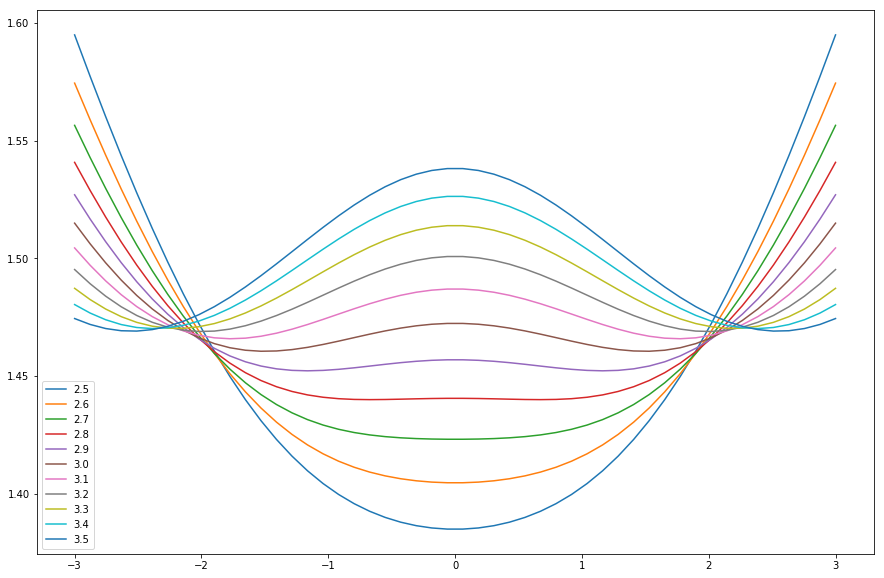

In [9]:
locs = np.linspace(-3, 3)
x = pd.DataFrame([(-slow_risk(0, loc, 1), -slow_risk(0, -loc, 1)) for loc in locs], columns=['EL','EG'])

plt.figure(figsize=(15, 10))
for p in np.linspace(2.5, 3.5, 11):
    _p = 1/p
    a, b = (x.EL)**_p, (x.EG)**_p
    plt.plot(locs, a+b, label=p);
plt.legend()

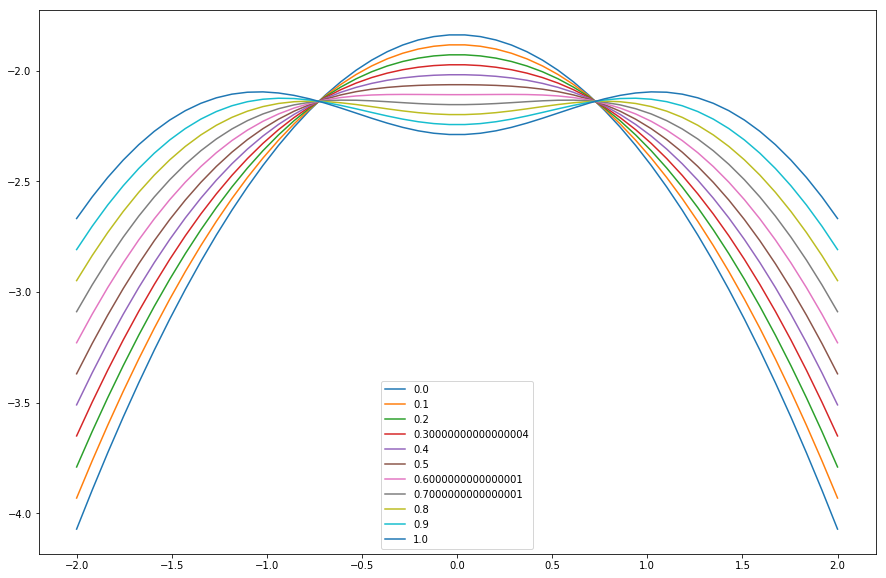

In [10]:
locs = np.linspace(-2, 2)
x = pd.DataFrame([(-slow_risk(0, loc, 1), -slow_risk(0, -loc, 1)) for loc in locs], columns=['EL','EG'])
plt.figure(figsize=(15, 10))
for p in np.linspace(0, 1, 11):
    foo = p*np.log(x.EL+x.EG)
    a, b = np.log(x.EL) + foo, np.log(x.EG) + foo
    plt.plot(locs, a+b, label=p);
plt.legend()

     sample_size_0  sample_size_1      sum_0      sum_1  sumOfSquares_0  \
986            498            502 -41.978185 -14.674894      503.731595   
986            488            512   5.041414  -1.382248      506.349318   
989            522            478  -2.582314   9.632899      500.404247   
990            513            487   1.758573 -15.810266      558.064017   
987            465            535  43.944730  -0.498628      468.438365   

     sumOfSquares_1  total_sample_size  estimated_mean_0  \
986      476.679729               1000         -0.084294   
986      451.159513               1000          0.010331   
989      475.181971               1000         -0.004947   
990      443.152405               1000          0.003428   
987      517.519435               1000          0.094505   

     estimated_variance_0  estimated_mean_1  estimated_variance_1  \
986              1.004404         -0.029233              0.948707   
986              1.037494         -0.002700       

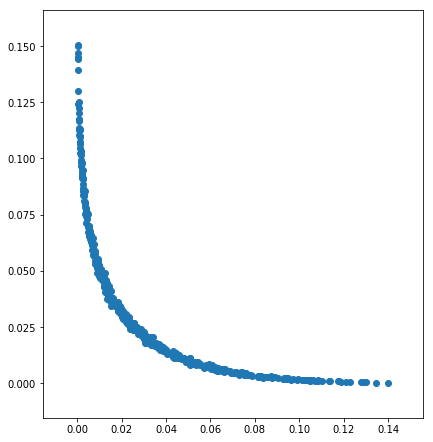

In [11]:
# trying to see if, for a fixed variance, there is a simple relationship between EL and EG
stopping_condition = 'total_sample_size >= 1000'
NUMBER_OF_SIMULATIONS=500

def _plotter():
    for means in [[0,0]]:
        yield
        lasts = []
        for _ in range(NUMBER_OF_SIMULATIONS):
            sim = one_simulation_until_stopping_condition(
                weights = [0.5, 0.5],
                means = means,
                stdevs = [1, 1],
                stopping_condition = stopping_condition)
            last=sim.tail(1)
            lasts.append(last)
        df = pd.concat(lasts)
        print(df.head())
        plt.scatter((-df.EL)**(1/1), (df.EG)**(1/1))
        #plt.figure()
        #plt.plot(df.posterior_stdev.sort_values().values)
        
%time multiplot_from_generator(_plotter(), 2)

CPU times: user 14.7 s, sys: 831 ms, total: 15.6 s
Wall time: 14.5 s


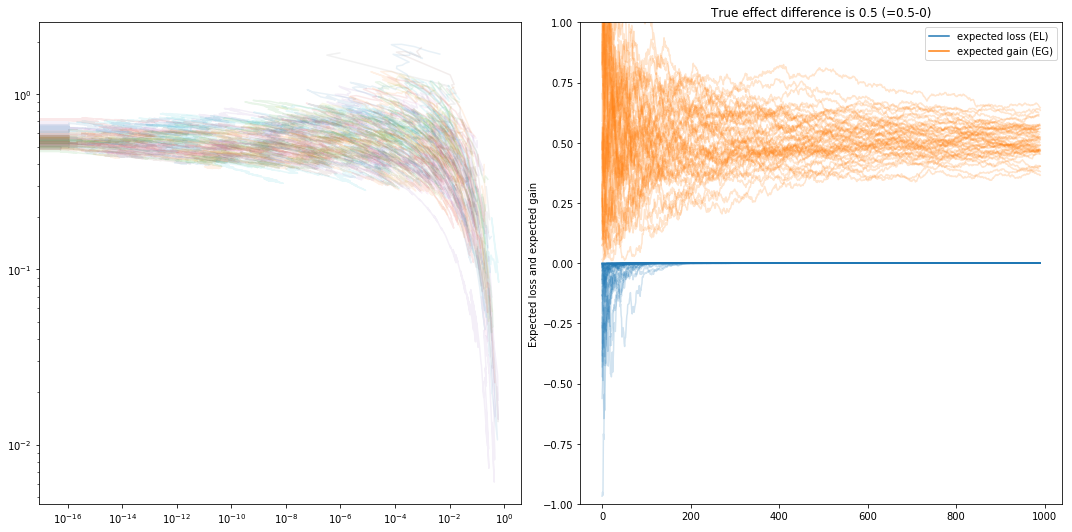

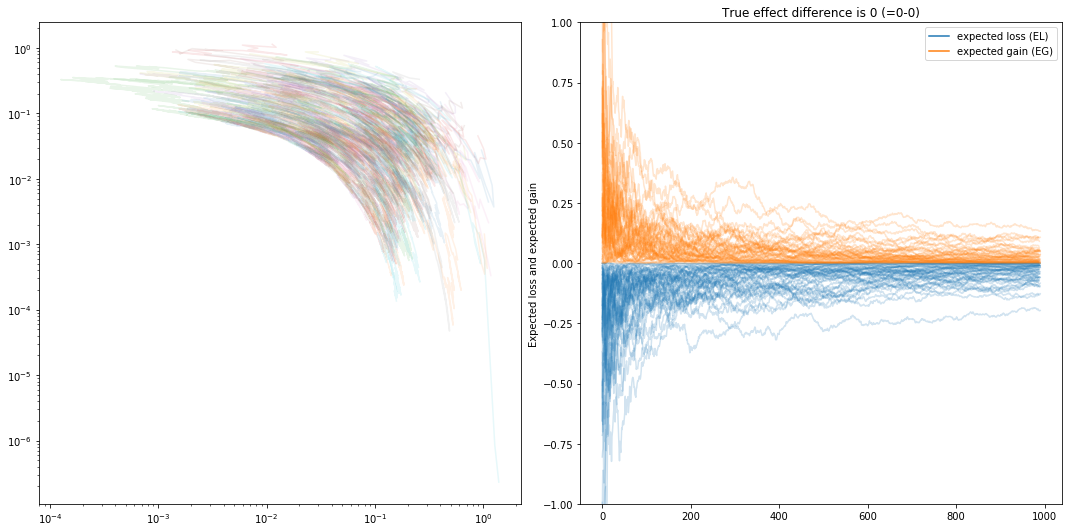

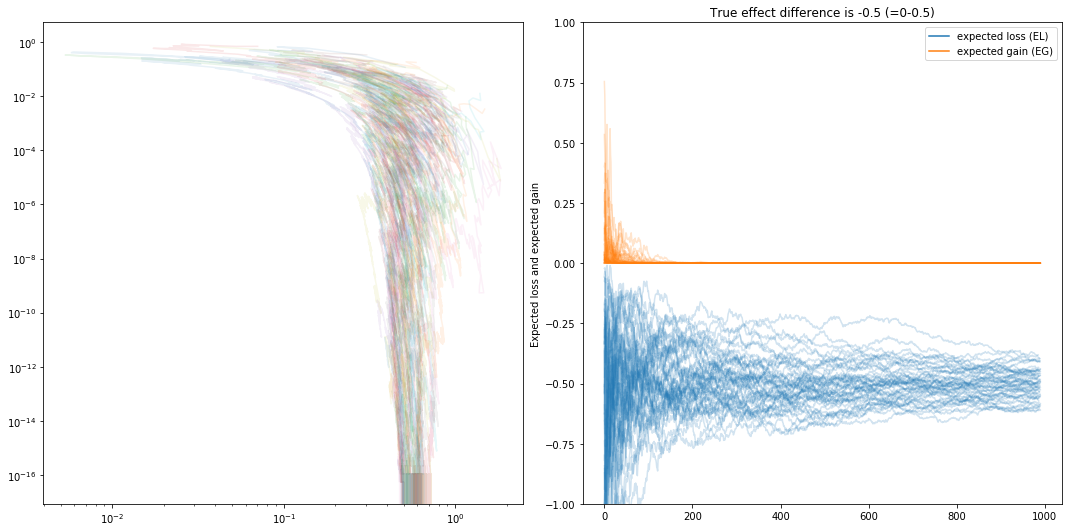

In [12]:
stopping_condition = 'total_sample_size >= 1000'
NUMBER_OF_SIMULATIONS=50

def _plotter():
    for means in [([0, 0.5]), ([0,0]), ([0.5, 0])]:
        
        yield
        for _ in range(NUMBER_OF_SIMULATIONS):
            sim = one_simulation_until_stopping_condition(
                weights = [0.5, 0.5],
                means = means,
                stdevs = [1, 1],
                stopping_condition = stopping_condition)
            # plotting, with the correct colour
            plt.loglog(-sim.EL, sim.EG, alpha=0.1)
        
        yield
        # First, two 'fake' plots to get a nice legend and store the colours
        el_line, = plt.plot([], [], label='expected loss (EL)');
        eg_line, = plt.plot([], [], label='expected gain (EG)');
        plt.legend()
        
        # Now do all the simulations, plotting EL and EG for each
        for _ in range(NUMBER_OF_SIMULATIONS):
            sim = one_simulation_until_stopping_condition(
                weights = [0.5, 0.5],
                means = means,
                stdevs = [1, 1],
                stopping_condition = stopping_condition)
            # plotting, with the correct colour
            plt.plot(sim.EL, color=el_line.get_color(), alpha=0.2)
            plt.plot(sim.EG, color=eg_line.get_color(), alpha=0.2)
        plt.title('True effect difference is {} (={}-{})'.format(means[1]-means[0], means[1], means[0]))
        plt.ylabel('Expected loss and expected gain')
        plt.tight_layout()
        plt.ylim(-1, 1)
        
%time multiplot_from_generator(_plotter(), 2)

## "Threshold of caring"

The _threshold of caring_ is a heuristic used to decide when to stop the experiment. If we set the _threshold of caring_ to 

$$\tau=0.01$$

then we run the experiment until either:

$$  EL > -\tau $$
or
$$  EG < \tau $$

To investigate this, we need to run simulations where we specify:

 - the true effect, $\Delta$, which is the difference in the true means
 - the _threshold of caring_, $toc$

and then we analyse the final values, after the threshold has been reached, of these three quantities:

 - EL
 - EG
 - estimated effect, $\hat\Delta$, i.e. the difference between the estimate sample means

In [29]:
current_scheme = 2
current_scheme = 'TimesSum'

def _stop1(REGEL_RATIO, toc_large):
    toc_small = toc_large / REGEL_RATIO
    toc_sum  = toc_large + toc_small
    stopping_condition = """(-EL) < {toc_small} | EG < {toc_small} | EG-EL < {toc_sum}""".format(**locals())
    return stopping_condition
def _stop2(REGEL_RATIO, toc_large):
    toc_small = toc_large / REGEL_RATIO
    toc_sum = toc_large**(1/3) + toc_small**(1/3)
    stopping_condition = """(-EL) < {toc_small} | EG < {toc_small} | EG**(1/3) + (-EL)**(1/3) < {toc_sum}""".format(**locals())
    return stopping_condition
def _stopTimesSum(REGEL_RATIO, toc_large):
    toc_small = toc_large / REGEL_RATIO
    thresh = np.log(toc_large) + np.log(toc_small) + np.log(toc_large + toc_small)
    stopping_condition = """log(-EL) + log(EG) + log(EG-EL) < {thresh}""".format(**locals())
    return stopping_condition

_REGELRATIOs1 = [1000, 700, 400, 200, 100, 70, 40, 20, 10]
_REGELRATIOs2 = [1000, 700, 400, 200, 100, 70, 40, 20, 10]
_REGELRATIOsTimesSum = [1000, 700, 600, 500, 400, 300, 200, 100, 70, 40, 20, 10]
_toc_larges1 = [        0.003, # included in _stop1
                      0.004,
                      0.007,
                      0.010,
                      0.020,
                      0.040,
                      0.070,
                      0.100,
                      0.200,
                      0.400,
                     ]
_toc_larges2 = [      # 0.003, # included in _stop1
                      #0.004, #included in _stop2
                      0.007,
                      0.010,
                      0.020,
                      0.040,
                      0.070,
                      0.100,
                      0.200,
                      0.400,
                     ]
_toc_largesTimesSum = [      # 0.003, # included in _stop1
                      #0.004, #included in _stop2
                      #0.007,
                      #0.010,
                      0.020,
                      0.025,
                      0.030,
                      0.035,
                      0.040,
                      0.045,
                      0.050,
                      0.055,
                      0.060,
                      0.065,
                      0.070,
                      0.075,
                      0.100,
                      0.200,
                      0.400,
                     ]
REGEL_RATIOs = eval('_REGELRATIOs{}'.format(current_scheme))
toc_larges = eval('_toc_larges{}'.format(current_scheme))
_stop = eval('_stop{}'.format(current_scheme))

stopping_conditions = [
    _stop(REGEL_RATIO, toc_large)
    for REGEL_RATIO in REGEL_RATIOs
    for toc_large in toc_larges 
]
print(len(stopping_conditions))
print(stopping_conditions[0])

180
log(-EL) + log(EG) + log(EG-EL) < -18.642824794933492


0(234) 1(10257) 2(7592) 3(6557) 4(43110) 5(10780) 6(5604) 7(15344) 8(18006) 9(19154) 10(13093) 11(17722) 12(4420) 13(18621) 14(16023) 15(5071) 16(17363) 17(8240) 18(31907) 19(9679) 20(5549) 21(23403) 22(16301) 23(10051) 24(47141) 25(20754) 26(12523) 27(21683) 28(7671) 29(16039) 30(31350) 31(9932) 32(9439) 33(27394) 34(15042) 35(7466) 36(16710) 37(27290) 38(19247) 39(8613) 40(8439) 41(24303) 42(19069) 43(14063) 44(25000) 45(11550) 46(39944) 47(20405) 48(20351) 49(4602) 50(22337) 51(12184) 52(17728) 53(9198) 54(7000) 55(13854) 56(32441) 57(24097) 58(27681) 59(8735) 60(9113) 61(6082) 62(32927) 63(14155) 64(29559) 65(26711) 66(19145) 67(30736) 68(15996) 69(35849) 70(7416) 71(6836) 72(9297) 73(41763) 74(5757) 75(15910) 76(9977) 77(10734) 78(9188) 79(14396) 80(13391) 81(11792) 82(21207) 83(13369) 84(7047) 85(7608) 86(7784) 87(19121) 88(8084) 89(16516) 90(9757) 91(20084) 92(19540) 93(13305) 94(14103) 95(13513) 96(18518) 97(11790) 98(10032) 99(16593) 100(9301) 101(12500) 102(12705) 103(10830) 

776(8062) 777(22485) 778(15476) 779(4690) 780(33602) 781(12574) 782(17065) 783(23939) 784(17912) 785(6161) 786(19108) 787(15692) 788(27643) 789(3958) 790(20609) 791(10712) 792(12401) 793(15867) 794(24232) 795(13793) 796(15330) 797(23434) 798(15960) 799(7001) 800(20405) 801(21318) 802(18924) 803(13374) 804(22897) 805(21371) 806(9707) 807(30215) 808(8463) 809(12874) 810(9336) 811(6723) 812(4149) 813(10500) 814(21286) 815(22862) 816(19217) 817(18670) 818(15219) 819(11611) 820(18023) 821(22232) 822(21369) 823(13132) 824(10554) 825(3978) 826(4736) 827(12030) 828(25641) 829(39312) 830(17142) 831(15466) 832(24551) 833(10878) 834(12777) 835(1029) 836(15149) 837(14111) 838(13399) 839(12885) 840(8065) 841(6868) 842(11212) 843(16842) 844(6779) 845(25974) 846(8873) 847(14651) 848(11063) 849(23063) 850(20985) 851(10180) 852(11623) 853(7071) 854(8974) 855(14876) 856(21452) 857(13108) 858(14979) 859(22520) 860(11112) 861(14391) 862(11296) 863(8883) 864(13696) 865(16017) 866(31144) 867(21888) 868(1615

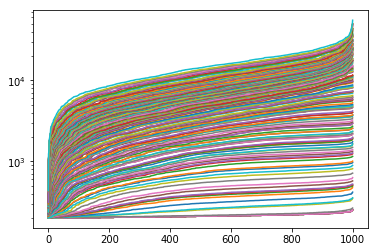

In [31]:
def caching_many_runs_many_stops(stopping_conditions, **kw):
    # many_sims_many_stopping_conditions
    with cache:
        return cache.simple('many_sims_many_stops',
                            'lambda stop_conds, **k: many_sims_many_stopping_conditions(1000, stop_conds, True)(**k)',
                            (stopping_conditions,),
                            kw)
df = caching_many_runs_many_stops(
        stopping_conditions,
        min_sample_size = 100,
        means = [7, 7+0.05],
        stdevs = [1, 1],
        weights = [0.5, 0.5],
)
for stop, _ in df.groupby('stopping_condition'):
    #plt.plot(_.sort_values('total_sample_size').total_sample_size.values, label=stop)
    plt.semilogy(_.total_sample_size.sort_values().values, label=stop)
#plt.legend()

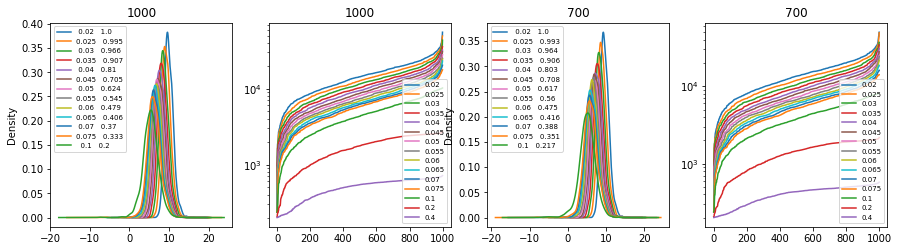

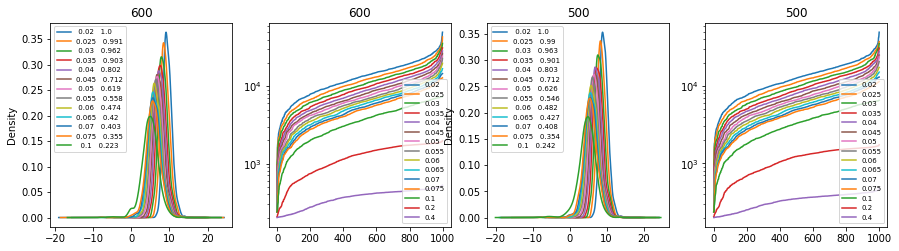

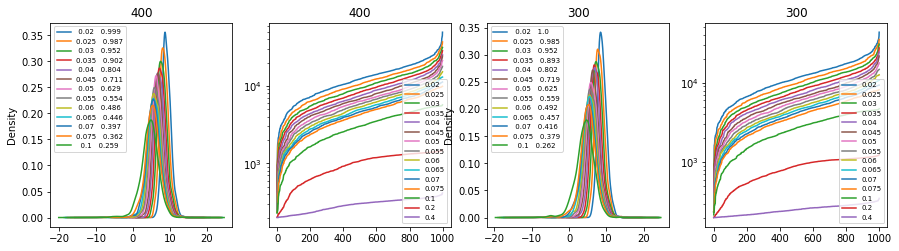

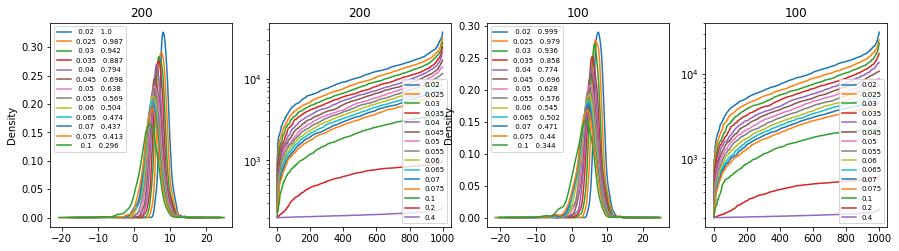

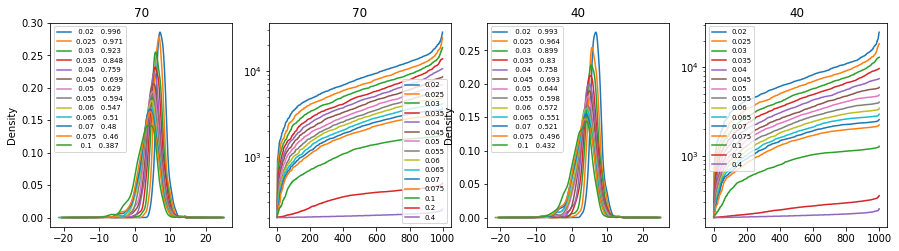

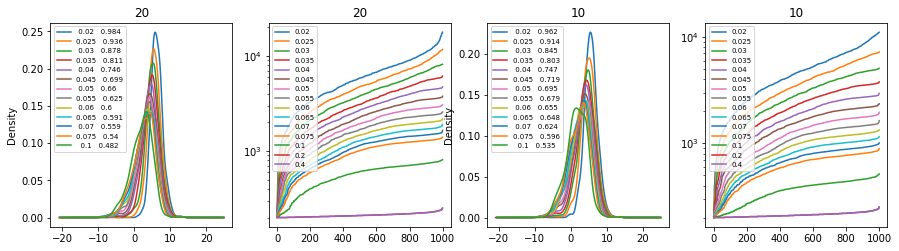

In [32]:
def _yielder_of_plots():
    for REGEL_RATIO in REGEL_RATIOs:
        yield
        plt.title(REGEL_RATIO)
        for toc_large in toc_larges[:-2]:
            stopping_condition = _stop(REGEL_RATIO, toc_large)
            assert stopping_condition in stopping_conditions
            one_sim = df.query('stopping_condition == @stopping_condition')
            lregel = one_sim.eval('log(EG)-log(-EL)')
            t1 = (abs(lregel) > np.log(REGEL_RATIO)).mean()
            lregel.plot.kde(label='{:5}   {}'.format(toc_large, t1))
        plt.legend(fontsize='x-small')
        yield
        plt.title(REGEL_RATIO)
        for toc_large in toc_larges:
            stopping_condition = _stop(REGEL_RATIO, toc_large)
            assert stopping_condition in stopping_conditions
            one_sim = df.query('stopping_condition == @stopping_condition')
            plt.semilogy(one_sim.total_sample_size.sort_values().values, label=toc_large)
        plt.legend(fontsize='x-small')
multiplot_from_generator(_yielder_of_plots(), 4)

In [16]:
#
fin
def caching_many_runs(*pos, **kw):
    with cache:
        return cache.simple('many_sims200',
                            'many_simulations_to_the_stopping_condition(200, trace=True)',
                            pos,
                            kw)

def foo(true_diff=0, weights = [0.5, 0.5], stdevs = [1, 1]):
    print('{}\t{}\t{}'.format(true_diff, weights, stdevs))
    one_set = caching_many_runs(
        min_sample_size = 100,
        stopping_condition = stopping_condition_1,
        means = [7, 7+true_diff],
        stdevs = stdevs,
        weights = weights)
    return one_set

#for weights in [[0.5, 0.5]]: %time foo(weights = weights)
#for stdevs in [[1, 1]]: %time foo(stdevs = stdevs)
#for true_diff in [0, 0]: %time foo(true_diff = true_diff)
    
#df = foo(true_diff=0.000) # 5%
#df = foo(true_diff=0.001) # 3%
#df = foo(true_diff=0.002) # 8%
#df = foo(true_diff=0.004) # 39%
#df = foo(true_diff=0.006) # 67.5%
#df = foo(true_diff=0.007) # 80%
#df = foo(true_diff=0.008) # 92.5
#df = foo(true_diff=0.010) # 97%

NameError: name 'fin' is not defined

In [ ]:
lksdjfds

def caching_many_runs(*pos, **kw):
    with cache:
        return cache.simple('many_sims200',
                            'many_simulations_to_the_stopping_condition(200, trace=True)',
                            pos,
                            kw)

REGEL_RATIO = 1000
toc_large = 0.003

toc_small = toc_large / REGEL_RATIO
stopping_condition_1 = """(-EL) <  {toc_small} | EG < {toc_small} | EG-EL < {toc_small}+{toc_large}""".format(**locals())

def foo(true_diff=0, weights = [0.5, 0.5], stdevs = [1, 1]):
    print('{}\t{}\t{}'.format(true_diff, weights, stdevs))
    one_set = caching_many_runs(
        min_sample_size = 100,
        stopping_condition = stopping_condition_1,
        means = [7, 7+true_diff],
        stdevs = stdevs,
        weights = weights)
    return one_set

#for weights in [[0.5, 0.5]]: %time foo(weights = weights)
#for stdevs in [[1, 1]]: %time foo(stdevs = stdevs)
#for true_diff in [0, 0]: %time foo(true_diff = true_diff)
    
#df = foo(true_diff=0.000) # 5%
#df = foo(true_diff=0.001) # 3%
#df = foo(true_diff=0.002) # 8%
#df = foo(true_diff=0.004) # 39%
#df = foo(true_diff=0.006) # 67.5%
#df = foo(true_diff=0.007) # 80%
#df = foo(true_diff=0.008) # 92.5
#df = foo(true_diff=0.010) # 97%


In [ ]:
#last_rows_orig     = get_one_row_per_simulation(df)

stopping_condition_2 = stopping_condition_1
last_rows_stricter = get_one_row_per_simulation(df, stopping_condition_2)
last_rows_stricter.eval('regel = log(EG) - log(-EL)', inplace=True)
#print(last_rows_stricter.sort_values('total_sample_size'))
_ = last_rows_stricter.sort_values('total_sample_size').reset_index(drop=True)
#print(_)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.scatter(-_.EL.values,
            _.EG.values,
            color =[ "green" if r>np.log(REGEL_RATIO) else
                    "red" if   -r<np.log(REGEL_RATIO) else
                    "grey" for r in _.regel]
           )
plt.figure()
plt.semilogy(_.total_sample_size.values)
plt.legend(['TypeI {} Runtime {}'.format((_.regel>np.log(REGEL_RATIO)).mean(), _.total_sample_size.mean())]);